# Parametric shape optimization with differentiable FEM simulation


## Setup

In [1]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [2]:
# import tesseract_core

# tesseract_core.build_tesseract("sdf_fd_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

In [1]:
# The PyMAPDL Host (X.X.X.X IP Address) and Port (XXX) are pulled from the environment
import os

MAPDL_HOST = os.getenv("MAPDL_HOST")
MAPDL_HOST = "172.26.3.4"

MAPDL_PORT = os.getenv("MAPDL_PORT")
MAPDL_PORT = "50050"

SPACECLAIM_HOST = os.getenv("SPACECLAIM_HOST")
SPACECLAIM_HOST = "172.26.5.4"

SPACECLAIM_PORT = os.getenv("SPACECLAIM_PORT")
SPACECLAIM_PORT = 443

SPACECLAIM_CALL = "F:\\Ansys\\ANSYS Inc\\v242\\scdm\\SpaceClaim.exe"

## Design Space Tesseract

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference
from utils import (
    MMAOptimizer,
    hex_grid,
    hex_to_pyvista,
    plot_grid,
    plot_grid_slice,
    plot_mesh,
)

from tesseract_jax import apply_tesseract
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference
from utils import hex_to_pyvista, plot_grid, plot_grid_slice, plot_mesh, stop_grads_int

from tesseract_jax import apply_tesseract

In [3]:
design_tess = Tesseract.from_tesseract_api("sdf_fd_tess/tesseract_api.py")
stl_tess = Tesseract.from_url(f"http://{SPACECLAIM_HOST}:{SPACECLAIM_PORT}")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [4]:
Nx, Ny, Nz = 100, 80, 4
Lx, Ly, Lz = 50, 40, 2

grid_fin_params = {
    "angular_positions": jnp.array(
        [
            [0, 3.14],
            [0.39, 3.53],
            [0.79, 3.93],
            [1.18, 4.32],
            [1.57, 4.71],
            [1.96, 5.11],
            [2.36, 5.50],
            [2.75, 5.89],
        ]
    ),
    "plane_height": 400,
    "plane_thickness": 100,
    "cuttin_plane_1": 200,
    "cuttin_plane_2": 200,
}

# lets create a flat parameter array from the grid fin params
init_diffable_params = jnp.concatenate(
    [
        jnp.array(
            [grid_fin_params["cuttin_plane_1"], grid_fin_params["cuttin_plane_2"]]
        ),
        grid_fin_params["angular_positions"].flatten(),
    ]
).astype(jnp.float32)

normalization_factors = 1 / jnp.array([1000, 1000] + [3.14 * 2] * 16, dtype=jnp.float32)
normalization_bias = jnp.zeros_like(normalization_factors)


def normalize(params, norms, bias):
    return params * norms + bias


def denormalize(params, norms, bias):
    return (params - bias) / norms


init_diffable_params = normalize(
    init_diffable_params, normalization_factors, normalization_bias
)

non_diffable_paramas = jnp.array(
    [
        grid_fin_params["plane_height"],
        grid_fin_params["plane_thickness"],
    ],
    dtype=jnp.float32,
)

design_inputs = {
    "non_differentiable_parameters": non_diffable_paramas,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "static_parameters": [],
    "string_parameters": [
        SPACECLAIM_CALL,
        "geometry_generation.scscript",
    ],
    "mesh_tesseract": TesseractReference(stl_tess),
    # the z coordinate of the object is not centered, hence we need to offset the SDF grid origin
    "grid_center": [0.0, 0.0, Lz / 2],
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "scale_mesh": 0.01,
    "max_points": 1000,
    "max_faces": 2000,
    "precompute_jacobian": True,
    "normalize_jacobian": False,
    "sdf_backend": "pyvista",
    "epsilon": 0.001,
}

print(init_diffable_params)

[0.2        0.2        0.         0.49999997 0.0621019  0.56210184
 0.12579617 0.62579614 0.18789807 0.68789804 0.24999999 0.74999994
 0.3121019  0.81369424 0.37579614 0.8757961  0.43789804 0.937898  ]


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

In [5]:
design_out = apply_tesseract(
    design_tess,
    {
        "differentiable_parameters": init_diffable_params,
        **design_inputs,
    },
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

Starting Jacobian precomputation thread...
Number of vertices: 224
Number of faces: 516


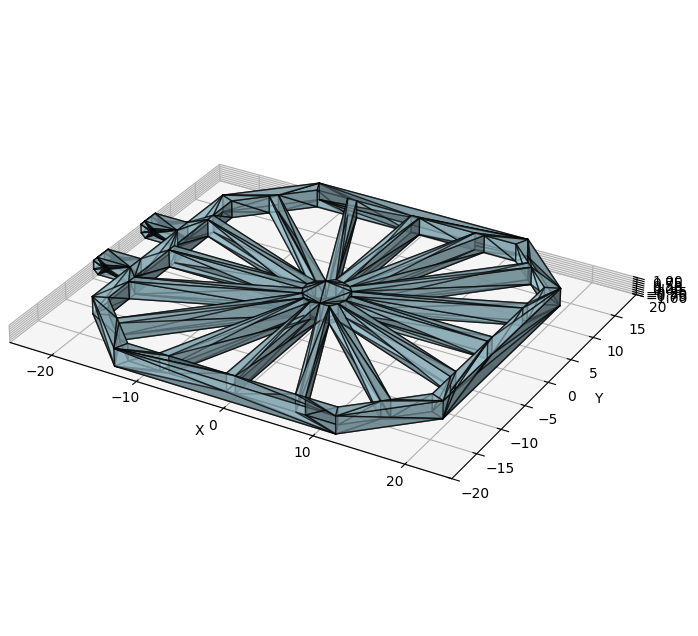

In [6]:
plot_mesh(mesh, [Lx, Ly, Lz])

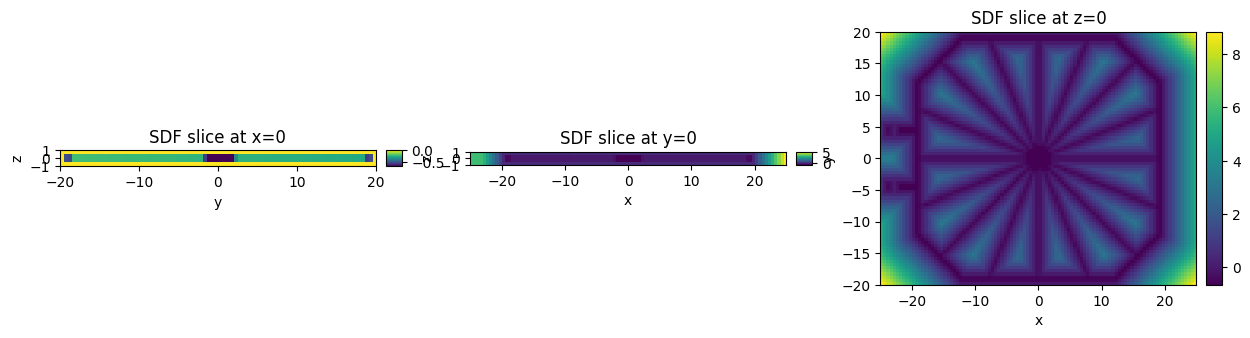

In [7]:
plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz, "SDF")

## Density Variation

rho min: 0.0006493852706626058, rho max: 0.8972160220146179


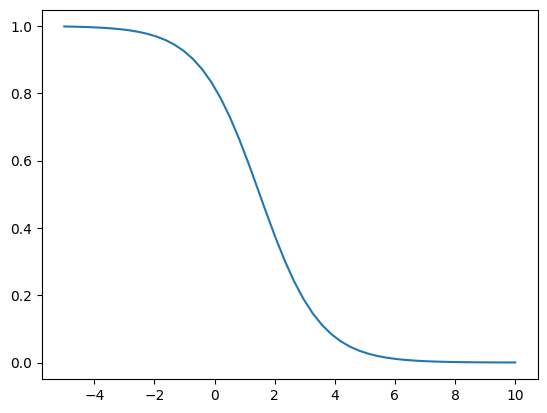

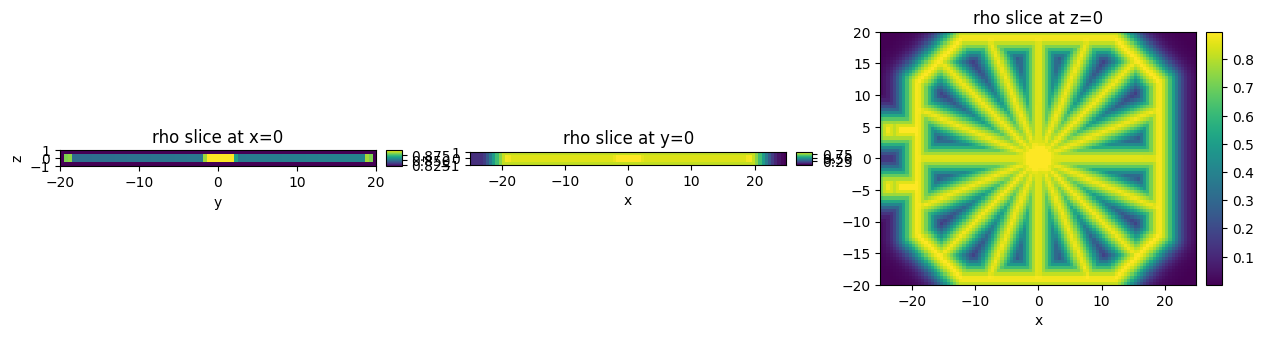

In [8]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho_scale = 1.0
rho_offset = 1.5

# plot the functions
sdfs = jnp.linspace(-5, 10)
rhos = sdf_to_rho(sdfs, scale=rho_scale, offset=rho_offset)

plt.plot(sdfs, rhos)


rho = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz, "rho")
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

## Hex Mesh

In [9]:
points, cells = hex_grid(Lx, Ly, Lz, Nx + 1, Ny + 1, Nz + 1)

hex_mesh = {
    "points": points,
    "faces": cells,
    "n_points": jnp.array(points.shape[0]),
    "n_faces": jnp.array(cells.shape[0]),
}

Lets examine the produced mesh by exporting it to a VTK file and visualizing it in Paraview.

In [10]:
pv_mesh = hex_to_pyvista(
    hex_mesh["points"],
    hex_mesh["faces"],
    {"rho": rho.flatten()},
)

print(pv_mesh)

pv_mesh.save("tmp_vtks/fin_mesh.vtk")

UnstructuredGrid (0x76c8dc112ec0)
  N Cells:    32000
  N Points:   40905
  X Bounds:   -2.500e+01, 2.500e+01
  Y Bounds:   -2.000e+01, 2.000e+01
  Z Bounds:   -1.000e+00, 1.000e+00
  N Arrays:   1


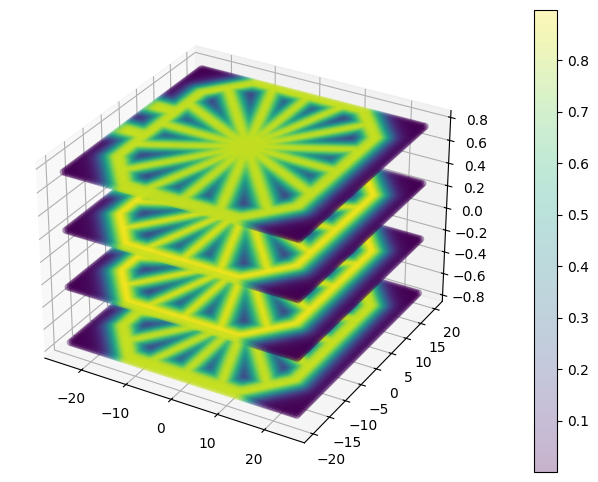

In [11]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = hex_mesh["points"]
hex_cells = hex_mesh["faces"]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = rho.flatten()
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    alpha=0.3,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

## Boundary Conditions

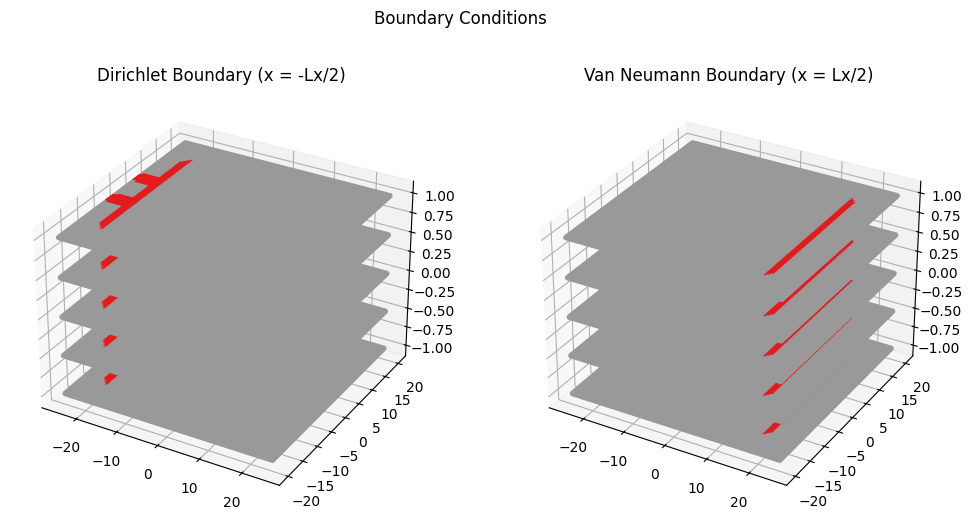

In [14]:
# Lets setup the boundary conditions
def get_boundary_masks(mesh: dict, Lx: float, Lz: float, sdf: jnp.ndarray):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = jnp.logical_and(pts[:, 0] <= -Lx / 2 + Lx / 8, sdf.flatten() < 0.75)
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], (Lx / 2) - Lx / 7.6, atol=Lx / 64), sdf.flatten() < 0.75
    )

    return dirichlet_mask, van_neumann_mask

sdf_points = jnp.pad(sdf, [[0, 1], [0, 1], [0, 1]], mode="symmetric")
dirichlet_mask, van_neumann_mask = get_boundary_masks(hex_mesh, Lx, Lz, sdf_points)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
pts = hex_mesh["points"]
axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask, 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask, 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

## Finite Element Analysis

In [15]:
# load the Finite Element Method Tesseract
fem_tess = Tesseract.from_tesseract_api("pymapdl_tess/tesseract_api.py")
# fem_tess = Tesseract.from_image("pymapdl_tess")
# fem_tess.serve()

In [28]:
# TODO unify this framework
dirichlet_idx = jnp.where(dirichlet_mask)[0]
von_neumann_idx = jnp.where(van_neumann_mask)[0]
von_neumann_values = jnp.array([0, 0.0, 0.1])/len(von_neumann_idx) + jnp.zeros((von_neumann_idx.shape[0], 3))

c = apply_tesseract(
    fem_tess,
    {
        "dirichlet_mask": dirichlet_idx,
        "dirichlet_values": jnp.zeros(dirichlet_idx.size),
        "van_neumann_mask": von_neumann_idx,
        "van_neumann_values": von_neumann_values,
        "hex_mesh": hex_mesh,
        "host": MAPDL_HOST,
        "port": MAPDL_PORT,
        "rho": jnp.expand_dims(rho.flatten(), axis=-1),
        "E0": 1.0,
        "rho_min": 1e-6,
        "log_level": "DEBUG",
        "vtk_output": "mesh_density.vtk",
    },
)["compliance"]

print(f"Compliance: {c:.4f}")

2025-11-26 08:31:59,040 - tesseract_api - INFO - Starting solve...
2025-11-26 08:31:59,042 - tesseract_api - INFO - Starting SIMP elasticity analysis...
2025-11-26 08:31:59,043 - tesseract_api - INFO - Starting _create_mesh...
2025-11-26 08:31:59,116 - tesseract_api - INFO - Starting _define_element...
2025-11-26 08:31:59,196 - tesseract_api - INFO - Completed _define_element in 0.0803 seconds
2025-11-26 08:31:59,197 - tesseract_api - INFO - Creating 40905 nodes...
2025-11-26 08:32:03,986 - tesseract_api - INFO - Creating 32000 hexahedral elements...
2025-11-26 08:32:07,548 - tesseract_api - INFO - Mesh created: 40905 nodes, 32000 elements
2025-11-26 08:32:07,550 - tesseract_api - INFO - Verified: Node and element numbering is sequential (1, 2, 3, ...)
2025-11-26 08:32:07,553 - tesseract_api - INFO - Completed _create_mesh in 8.5095 seconds
2025-11-26 08:32:07,554 - tesseract_api - INFO - Starting _define_simp_materials...
2025-11-26 08:32:12,872 - tesseract_api - INFO - Completed _def

Compliance: 21.9457


## Optimization Setup

In [29]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)

In [30]:
def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    # params = identity_and_store_grads(params, iteration + 0)
    design_out = apply_tesseract(
        design_tess,
        {"differentiable_parameters": params.flatten(), **design_inputs},
    )

    sdf = design_out["sdf"]
    sdf = identity_and_store_grads(sdf, iteration + 1000)

    # Convert SDF to material density distribution
    rho_grid = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)
    rho_grid = identity_and_store_grads(rho_grid, iteration + 2000)

    c = apply_tesseract(
        fem_tess,
        {
            "dirichlet_mask": dirichlet_idx,
            "dirichlet_values": jnp.zeros(dirichlet_idx.size),
            "van_neumann_mask": von_neumann_idx,
            "van_neumann_values": von_neumann_values,
            "hex_mesh": hex_mesh,
            "host": MAPDL_HOST,
            "port": MAPDL_PORT,
            "rho": jnp.expand_dims(rho_grid.flatten(), axis=-1),
            "E0": 1.0,
            "rho_min": 1e-6,
            "log_level": "WARNING",
            "vtk_output": None,
        },
    )["compliance"]

    return c, {"sdf": sdf, "rho_grid": rho_grid}

initial_params = init_diffable_params.copy()
grad_fn = jax.value_and_grad(loss, has_aux=True)

## Lets have a look at the gradients

In [31]:
(loss_value, aux), grads = grad_fn(initial_params, iteration=0)
print(f"loss {loss_value}, grads {grads}")

Starting Jacobian precomputation thread...
Storing values in hash 2000
Storing values in hash 1000
Using precomputed Jacobian...
Waiting for Jacobian precomputation to finish...
Jacobian precomputation finished.
Jacobian shape: (18, 100, 80, 4) and type: float32
loss 21.945714950561523, grads [ 9.9081020e+00  6.2867576e-01 -4.6080235e-01  1.9752416e-01
  6.7504483e-01 -1.3115824e+01 -3.5507321e-01  2.5729723e+01
 -2.7670693e+00  1.3052446e+01 -4.9308681e+00  2.8292866e+00
 -1.6801754e+01  3.1477628e+00 -2.1291895e+01 -3.2429963e-01
  1.5723641e+01 -4.6861470e-03]


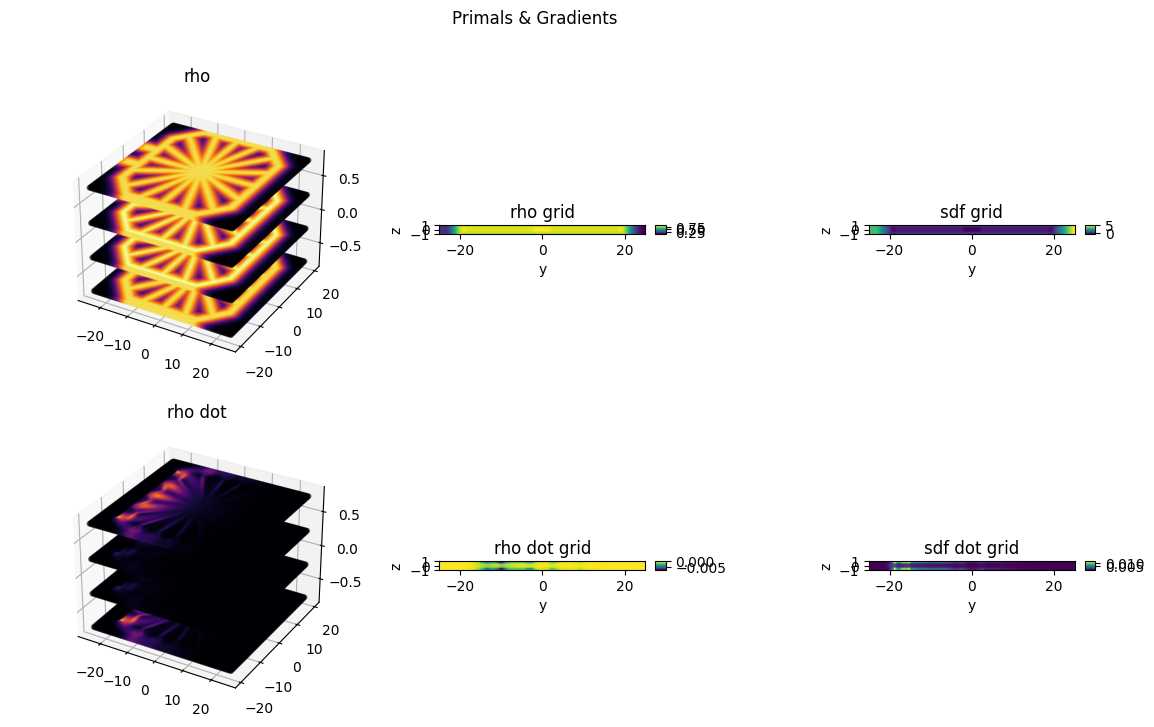

In [32]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
plt.suptitle("Primals & Gradients")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

ax = axs[0, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

ax = axs[1, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

# Set the first two subplots to 3D
axs[0, 0] = fig.add_subplot(2, 2, 1, projection="3d")
axs[1, 0] = fig.add_subplot(2, 2, 3, projection="3d")


mesh = hex_mesh

pts_coords = mesh["points"]
hex_cells = mesh["faces"]
pts = jnp.mean(pts_coords[hex_cells], axis=1)

axs[0, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=aux["rho_grid"],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[0, 0].set_title("rho")

axs[1, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=-grad_storage[2000][1],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[1, 0].set_title("rho dot")

plot_grid_slice(
    aux["rho_grid"][:, Ny // 2, :],
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[0, 1],
    title="rho grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.max(grad_storage[2000][1], axis=1),
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[1, 1],
    title="rho dot grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    aux["sdf"][:, Ny // 2, :],
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[0, 2],
    title="sdf grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.max(grad_storage[1000][1], axis=1),
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[1, 2],
    title="sdf dot grid",
    xlabel="y",
    ylabel="z",
)

fig.subplots_adjust(wspace=0.9)

### Finite difference check

In [41]:
params = initial_params.copy()

(loss_value, aux), grads = grad_fn(params, iteration=0)

# Finite difference check
run_central_difference = False
num_tests = 3
FD_delta = 1.0e-4
FD_grads = 0 * jnp.array(grads)
for i in range(num_tests):
    print(i)
    params_up = params.at[i].add(FD_delta)
    fupp, _ = loss(params_up)

    if run_central_difference:
        params_down = params.at[i].subtract(2.0 * FD_delta)
        fdown, _ = loss(params_down)
        FD_grads = FD_grads.at[i].set((fupp - fdown) / FD_delta / 2.0)

    else:
        FD_grads = FD_grads.at[i].set((fupp - loss_value) / FD_delta)

if num_tests > 0:
    sens = jnp.array(grads[0:num_tests])
    FD_sens = FD_grads[0:num_tests]
    print(sens)
    print(FD_sens)
    errors = sens - FD_sens
    print(errors)
    rel_abs_error = jnp.abs(errors / sens)
    if run_central_difference:
        print(f"Relative error should be near O({FD_delta})")
    else:
        print(f"Relative error should be O({FD_delta * 10})")
    print(rel_abs_error)

Starting Jacobian precomputation thread...
Storing values in hash 2000
Storing values in hash 1000
Using precomputed Jacobian...
Waiting for Jacobian precomputation to finish...
Jacobian precomputation finished.
Jacobian shape: (18, 100, 80, 4) and type: float32
0
Starting Jacobian precomputation thread...
1
Starting Jacobian precomputation thread...
2
Starting Jacobian precomputation thread...
[ 9.908102    0.62867576 -0.46080235]
[ 9.57489     0.45776367 -0.15258789]
[ 0.3332119   0.17091209 -0.30821446]
Relative error should be O(0.001)
[0.03363024 0.27186048 0.6688648 ]


## Design Optimization using MMA

In [37]:
print(initial_params)

[0.2        0.2        0.         0.49999997 0.0621019  0.56210184
 0.12579617 0.62579614 0.18789807 0.68789804 0.24999999 0.74999994
 0.3121019  0.81369424 0.37579614 0.8757961  0.43789804 0.937898  ]


In [ ]:
import importlib

import utils

importlib.reload(utils)
n_steps = 10

# set design bounds by a perturbation value 'delta'
param_min = initial_params.copy()
param_max = initial_params.copy()

# the cutting planes do not change
param_min = param_min.at[0].subtract(1.e-3)
param_min = param_min.at[1].subtract(1.e-3)

# the bars are free to rotate (from -pi to 2pi, normalized)
theta_min = -1
theta_max = 2
for i in range(2, len(initial_params)):
    param_min = param_min.at[i].set(theta_min)
    param_max = param_max.at[i].set(theta_max)
print(initial_params)
print(param_min)
print(param_max)
               

# A placeholder is used for constraint
num_constraints = 0
g = jnp.zeros((0, 1))
dgdx = jnp.zeros((0, initial_params.shape[0]))

# initialize the optimizer
x_update_limit = 0.0005
params = initial_params.copy()
loss_hist = []
params_hist = []
aux_hist = []
optimizer = MMAOptimizer(
    initial_params[:, None],
    param_min[:, None],
    param_max[:, None],
    num_constraints,
    x_update_limit=x_update_limit,
)


for i in range(n_steps):
    (loss_value, aux), grads = grad_fn(params, iteration=i)
    print(loss_value)
    print(params)
    print(grads)
    np_params = optimizer.calculate_next_x(loss_value, grads, g, dgdx, i + 1, params)
    params = jnp.array(np_params.flatten())

    loss_hist.append(loss_value)
    params_hist.append(params)
    aux_hist.append(aux)

    print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

[0.2        0.2        0.         0.49999997 0.0621019  0.56210184
 0.12579617 0.62579614 0.18789807 0.68789804 0.24999999 0.74999994
 0.3121019  0.81369424 0.37579614 0.8757961  0.43789804 0.937898  ]
[ 0.199  0.199 -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
 -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.   ]
[0.2 0.2 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2. ]


### Optimization Postprocess

Text(0.5, 1.0, 'Compliance over Optimization')

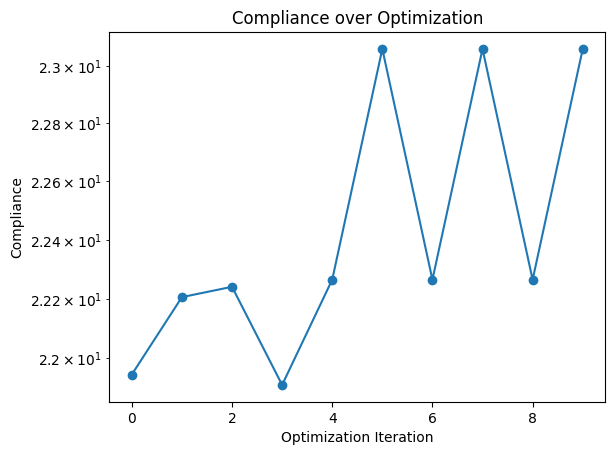

In [47]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

In [53]:
for i in range(n_steps):
    mesh = hex_mesh
    rho_dot = grad_storage[i + 2000][1][: len(mesh["faces"])]
    pv_mesh = hex_to_pyvista(
        mesh["points"],
        mesh["faces"],
        {"rho": aux_hist[i]["rho_grid"].flatten(), "rho_dot": rho_dot.flatten()},
    )
    pv_mesh.save(f"tmp_vtks/fem_shapeopt_mesh{i + 1}.vtk")

In [52]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

design_inputs["precompute_jacobian"] = False

ims = []
for aux in aux_hist:
    sdf = aux["sdf"]

    im = plt.imshow((sdf[:, :, :] > 0).sum(axis=2).T, origin="lower", cmap="viridis")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_fin_optim.gif", writer="pillow", fps=10)